In [0]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline


**Since new version for Tensorflow is available so we import the backend data and new files for v2(version 2) into v1(version 1)**

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Reading data from the CSV file using dataframe

In [0]:
df = pd.read_csv('../spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Dropping the outliers or unecessary empty data points

In [0]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
v1    5572 non-null object
v2    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


# Creating the plot for the categories

Text(0.5, 1.0, 'Number of ham and spam messages')

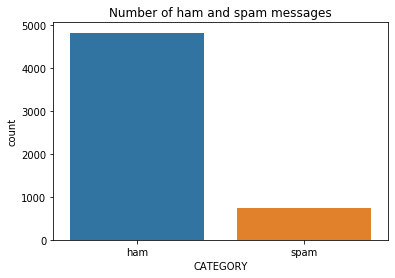

In [49]:
sns.countplot(df.v1)
plt.xlabel('CATEGORY')
plt.title('Number of ham and spam messages')

**Labeling and creating Input and Output vectors**

In [0]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

**Data splitting into test and train**

In [0]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

# Data processing 
* Tokenize the data
* Padding 

In [0]:
DATA_FILE = '../spam.csv'
df = pd.read_csv(DATA_FILE,encoding='latin-1')
print(df.head())

tags = df.v1
texts = df.v2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import time
from keras import metrics
print('import done')

     v1  ... Unnamed: 4
0   ham  ...        NaN
1   ham  ...        NaN
2  spam  ...        NaN
3   ham  ...        NaN
4   ham  ...        NaN

[5 rows x 5 columns]
import done


In [0]:
num_max = 1000
# preprocess
le = LabelEncoder()
tags = le.fit_transform(tags)
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(texts)
mat_texts = tok.texts_to_matrix(texts,mode='count')
print(tags[:5])
print(mat_texts[:5])
print(tags.shape,mat_texts.shape)

In [0]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y):
    model.fit(x,y,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

m = get_simple_model()
check_model(m,mat_texts,tags)

# **CNN**

In [0]:
# for cnn preproces
max_len = 100
cnn_texts_seq = tok.texts_to_sequences(texts)
print(cnn_texts_seq[0])
cnn_texts_mat = sequence.pad_sequences(cnn_texts_seq,maxlen=max_len)
print(cnn_texts_mat[0])
print(cnn_texts_mat.shape)

[50, 469, 841, 751, 657, 64, 8, 89, 121, 349, 147, 67, 58, 144]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  50 469 841 751
 657  64   8  89 121 349 147  67  58 144]
(5572, 100)


**Model v1**

In [0]:
def get_cnn_model_v1():   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        20,
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

m = get_cnn_model_v1()
check_model(m,cnn_texts_mat,tags)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 20)           20000     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 20)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 98, 64)            3904      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 256)              

**Model v2**

In [0]:
def get_cnn_model_v2(): # added embed   
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        50, #!!!!!!!!!!!!!!!!!!!!!!!
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

m = get_cnn_model_v2()
check_model(m,cnn_texts_mat,tags)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           50000     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 98, 64)            9664      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 256)              

**Model v3**

In [0]:
def get_cnn_model_v3():    # added filter
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    # 1000 is num_max
    model.add(Embedding(1000,
                        20,
                        input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(256, #!!!!!!!!!!!!!!!!!!!
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc',metrics.binary_accuracy])
    return model

m = get_cnn_model_v3()
check_model(m,cnn_texts_mat,tags)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 20)           20000     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 20)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 98, 256)           15616     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_9 (Activation)    (None, 256)              

**Test data processing**

In [0]:
 test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

**Test data evaluation**

In [0]:
accr = m.evaluate(test_sequences_matrix,Y_test)

836/836 [==============================] - 0s 154us/step


# **Print the final result**

In [0]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.043
  Accuracy: 0.992
